In [3]:
from train._utils import *
from models._utils import *
import time
from data._utils import *
from preprocess._utils import *
from data._utils import *

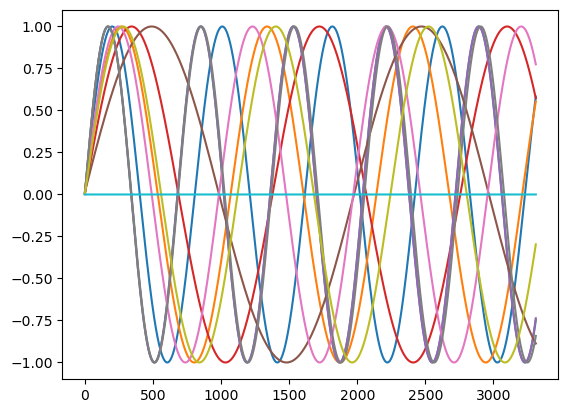

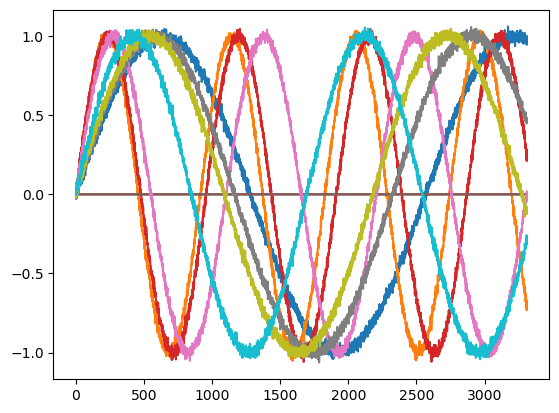

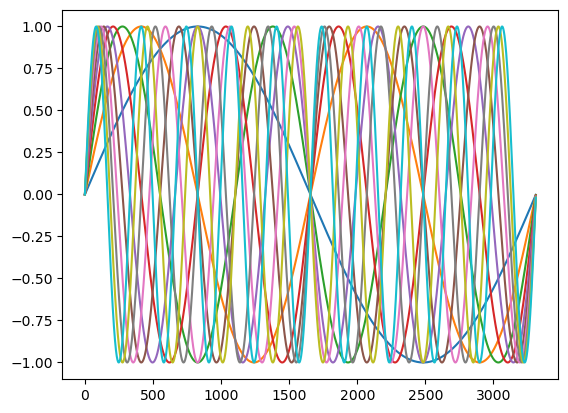

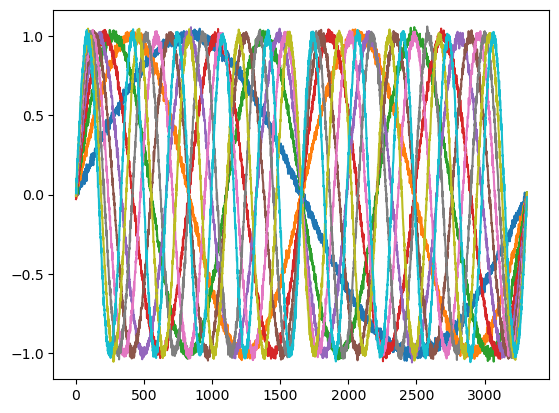

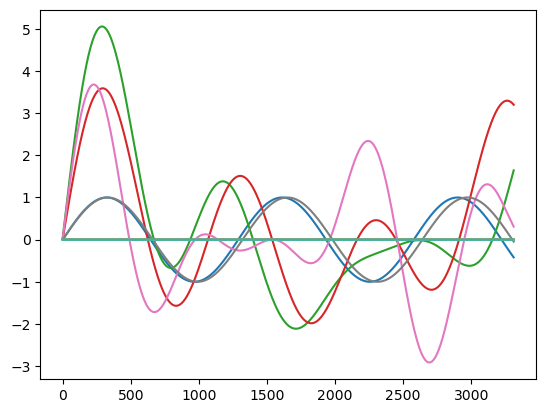

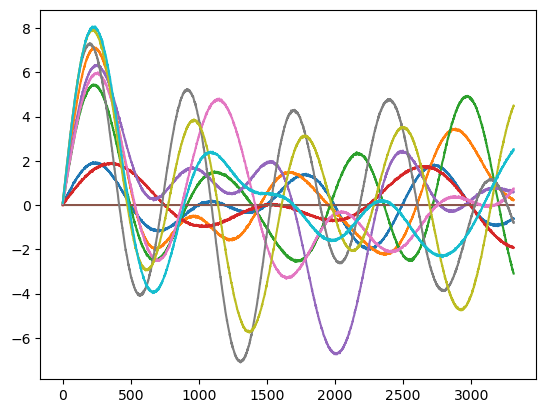

In [5]:


dataset = load_sine()
calcium_data = dataset["worm0"]["calcium_data"]
# print(dataset["worm0"]["named_neurons_mask"].sum())
plt.plot(calcium_data[:, 0:10])
plt.show()

dataset = load_sine_noise()
calcium_data = dataset["worm0"]["calcium_data"]
# print(dataset["worm0"]["named_neurons_mask"].sum())
plt.plot(calcium_data[:, 0:10])
plt.show()


dataset = load_sine_seq()
calcium_data = dataset["worm0"]["calcium_data"]
# print(dataset["worm0"]["named_neurons_mask"].sum())
plt.plot(calcium_data[:, 0:10])
plt.show()

dataset = load_sine_seq_noise()

calcium_data = dataset["worm0"]["calcium_data"]
# print(dataset["worm0"]["named_neurons_mask"].sum())
plt.plot(calcium_data[:, 0:10])
plt.show()

dataset = load_sum_sine()
calcium_data = dataset["worm0"]["calcium_data"]
# print(dataset["worm0"]["named_neurons_mask"].sum())
plt.plot(calcium_data[:, 0:10])
plt.show()


dataset = load_sum_sine_noise()
calcium_data = dataset["worm0"]["calcium_data"]
# print(dataset["worm0"]["named_neurons_mask"].sum())
plt.plot(calcium_data[:, 0:10])
plt.show()



NetworkLSTM(
  (lstm): LSTM(5, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=5, bias=True)
)


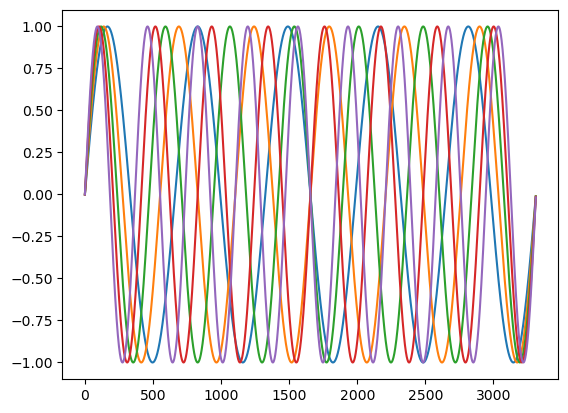

In [ ]:
#!/usr/bin/env python
# encoding: utf-8

from train._utils import *
from models._utils import *
import time
from data._utils import *

########################### Hyperparameters #########################
time_step = 100
BATCH_SIZE = 128
LR = 0.1
EPOCH = 10
num_worms_train = 1

CUTDOWN = 5
START = 4
smoothed = False
caltocal = True
split = 0.5
#####################################################################

model = NetworkLSTM(CUTDOWN, 64).double()
print(model)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = torch.nn.MSELoss()

dataset = load_sine_seq()
calcium_data = dataset["worm0"]["calcium_data"]
plt.plot(calcium_data[:, START:START+CUTDOWN])
plt.show()

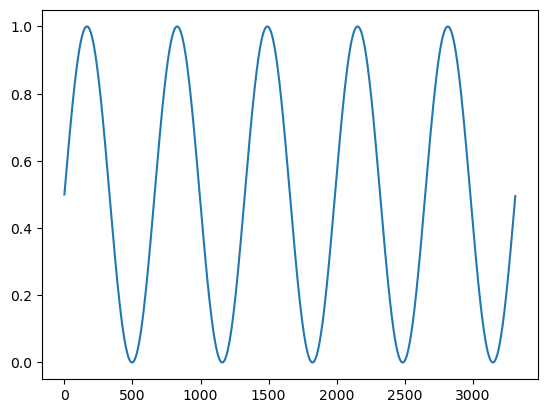

split:  0.5


--------worm No. 0--------


/var/folders/nh/w4w39l451_gbdf_6q7r0pg8w0000gn/T/ipykernel_9747/4239173399.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, requires_grad=True), torch.tensor(Y_train, requires_grad=True)
/var/folders/nh/w4w39l451_gbdf_6q7r0pg8w0000gn/T/ipykernel_9747/4239173399.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, Y_test = torch.tensor(X_test, requires_grad=True), torch.tensor(Y_test, requires_grad=True)


epoch = 0, train_loss = 0.2707, test_loss = 0.1528


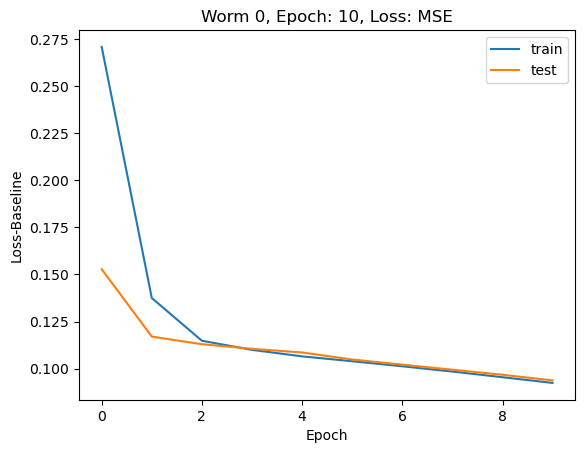

time =  182.486878156662


In [ ]:
for k in range(num_worms_train):
    worm = "worm" + str(k)
    if smoothed:
        calcium_data = dataset[worm]["smooth_calcium_data"][:, START:START+CUTDOWN]
        residual_calcium = dataset[worm]["residual_smooth_calcium"][:, START:START+CUTDOWN]
    else:
        calcium_data = dataset[worm]["calcium_data"][:, START:START+CUTDOWN]
        residual_calcium = dataset[worm]["residual_calcium"][:, START:START+CUTDOWN]

    # rescale
    for col in range(CUTDOWN):
        calcium_data[:, col] = (calcium_data[:, col] - calcium_data[:, col].min()) / (calcium_data[:, col].max() - calcium_data[:, col].min())

    plt.plot(calcium_data[:, 0])
    plt.show()

    cutdown = calcium_data.shape[0]
    train_size = int(split * cutdown)
    print("split: ", split)
    test_size = cutdown - train_size

    train_ca, test_ca = calcium_data.split(train_size, dim=0)
    train_res, test_res = residual_calcium.split(train_size, dim=0)

    train_loop_cal = []
    train_loop_res = []
    for i in range(0, train_ca.shape[0] - time_step):
        train_loop_res.append(np.array(train_res[i:i + time_step, :]))
        train_loop_cal.append(np.array(train_ca[i:i + time_step, :]))

    train_loop_cal = torch.tensor(np.array(train_loop_cal))
    train_loop_res = torch.tensor(np.array(train_loop_res))

    # print(train_loop_cal.shape, train_loop_res.shape)

    test_loop_cal = []
    test_loop_res = []
    for i in range(0, test_ca.shape[0] - time_step):
        test_loop_res.append(np.array(test_res[i:i + time_step, :]))
        test_loop_cal.append(np.array(test_ca[i:i + time_step, :]))

    test_loop_cal = torch.tensor(np.array(test_loop_cal))
    test_loop_res = torch.tensor(np.array(test_loop_res))

    train_loop_cal_target = torch.zeros_like(train_loop_cal)
    train_loop_cal_target[:-1] = train_loop_cal[1:]

    test_loop_cal_target = torch.zeros_like(test_loop_cal)
    test_loop_cal_target[:-1] = test_loop_cal[1:]

    if caltocal:
        train_dataset = torch.utils.data.TensorDataset(train_loop_cal, train_loop_cal_target)
        test_dataset = torch.utils.data.TensorDataset(test_loop_cal, test_loop_cal_target)
    else:
        train_dataset = torch.utils.data.TensorDataset(train_loop_cal, train_loop_res)
        test_dataset = torch.utils.data.TensorDataset(test_loop_cal, test_loop_res)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )

    print("\n")
    print("--------worm " + "No. " + str(k) + "--------")
    # train_loader = worm_train[i]
    # test_loader = worm_test[i]
    train_base_loss_history = []
    train_pred_loss_history = []
    test_base_loss_history = []
    test_pred_loss_history = []
    T1 = time.time()
    for e in range(EPOCH):
        train_base_loss = 0
        train_pred_loss = 0
        test_base_loss = 0
        test_pred_loss = 0
        count = 0
        for X_train, Y_train in train_loader:
            mask_train = dataset[worm]["named_neurons_mask"][:CUTDOWN]
            # mask_train = torch.full((mask_train.shape[0], ), False)
            # mask_train[0] = True
            X_train, Y_train = torch.tensor(X_train, requires_grad=True), torch.tensor(Y_train, requires_grad=True)
            optimizer.zero_grad()
            # Baseline: loss if the model predicted the residual to be 0
            base = criterion(X_train[:, :, mask_train], Y_train[:, :, mask_train])
            Y_tr = model(X_train * mask_train)
            Y_tr.retain_grad()
            Y_tr.register_hook(lambda grad: grad * mask_train.double())
            loss = criterion(Y_tr[:, :, mask_train], Y_train[:, :, mask_train])
            loss.backward(retain_graph=True)
            optimizer.step()  # Update parameters based on gradients.
            train_base_loss += base.detach().item()
            train_pred_loss += loss.detach().item()
            count += 1
        train_base_loss_history.append(train_base_loss / count)
        train_pred_loss_history.append(train_pred_loss / count)
        count = 0
        for X_test, Y_test in test_loader:
            mask_test = dataset[worm]["named_neurons_mask"][:CUTDOWN]
            # mask_test = torch.full((mask_test.shape[0], ), False)
            # mask_test[0] = True
            X_test, Y_test = torch.tensor(X_test, requires_grad=True), torch.tensor(Y_test, requires_grad=True)
            optimizer.zero_grad()  # Clear gradients.
            # Baseline: loss if the model predicted the residual to be 0
            base = criterion(X_test[:, :, mask_test], Y_test[:, :, mask_test])
            # X_test = X_test.reshape((1, X_test.shape[0], X_test.shape[1])).transpose(1, 2)
            Y_pred = model(X_test * mask_test)
            loss = criterion(Y_pred[:, :, mask_test], Y_test[:, :, mask_test])
            test_base_loss += base.detach().item()
            test_pred_loss += loss.detach().item()
            count += 1
        # print("Count = ", count)
        # print("Test X_test shape = ", X_test.shape)
        # print("Test Y_test shape = ", Y_test.shape)
        test_base_loss_history.append(test_base_loss / count)
        test_pred_loss_history.append(test_pred_loss / count)
        if e % int(0.1 * EPOCH)== 0:
            print("epoch = {}, train_loss = {:.4f}, test_loss = {:.4f}".format(e, train_pred_loss_history[-1] -
                                                                               train_base_loss_history[-1],
                                                                               test_pred_loss_history[-1] -
                                                                               test_base_loss_history[-1]))
        if len(test_pred_loss_history) > int(0.8 * EPOCH):
            if test_pred_loss_history[-1]-test_base_loss_history[-1] < test_pred_loss_history[-2]-test_base_loss_history[-2]:
                model_name = "model_3.pickle"
                file = open(model_name, "wb")
                torch.save(model.state_dict(), file)

    delta_train = [train_pred_loss_history[i] - train_base_loss_history[i] for i in
                   range(len(train_base_loss_history))]
    delta_test = [test_pred_loss_history[i] - test_base_loss_history[i] for i in range(len(test_base_loss_history))]
    # val loss decreses -> save model

    plt.plot(delta_train)
    plt.plot(delta_test)
    plt.legend(["train", "test"])
    plt.ylabel("Loss-Baseline")
    plt.xlabel("Epoch")
    plt.title("Worm " + str(k) + ", Epoch: " + str(EPOCH) + ", Loss: MSE")
    plt.show()
    T2 = time.time()


print("time = ", T2-T1)

## Prediction

In [1]:
if smoothed:
    calcium_data = dataset[worm]["smooth_calcium_data"][:, START:START+CUTDOWN]
    residual_calcium = dataset[worm]["residual_smooth_calcium"][:, START:START+CUTDOWN]
else:
    calcium_data = dataset[worm]["calcium_data"][:, START:START+CUTDOWN]
    residual_calcium = dataset[worm]["residual_calcium"][:, START:START+CUTDOWN]

for col in range(CUTDOWN):
    calcium_data[:, col] = (calcium_data[:, col] - calcium_data[:, col].min()) / (calcium_data[:, col].max() - calcium_data[:, col].min())

mask_test = dataset["worm0"]["named_neurons_mask"][:CUTDOWN]
# mask_test = torch.full((mask_test.shape[0], ), False)
# mask_test[0] = True


model = NetworkLSTM(CUTDOWN, 64).double()
model.load_state_dict((torch.load(model_name)))
model.eval()

# visualization of prediction
X_test = []
Y_test = []


time_step = 3310

for i in range(time_step, calcium_data.shape[0] - 1):
    X, Y = calcium_data[i - time_step:i], calcium_data[i-time_step + 1: i+1]
    X_test.append(np.array(X))
    Y_test.append(np.array(Y))

X_test = torch.tensor(X_test)
Y_test = torch.tensor(Y_test)

# print(mask_test)
Y_test = Y_test * mask_test
Y_pred = model(X_test * mask_test)

# extract inactive neurons

print(Y_pred.shape, Y_test.shape)

NameError: name 'smoothed' is not defined

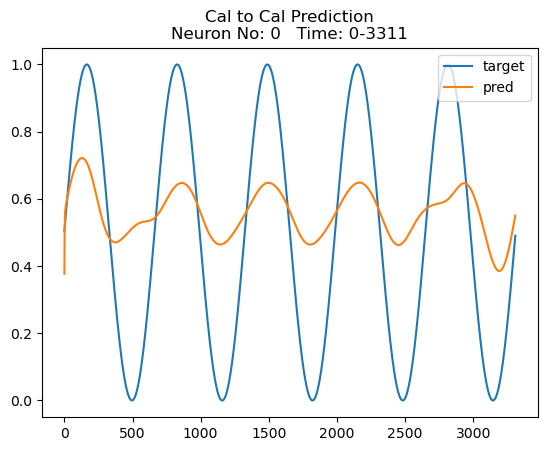

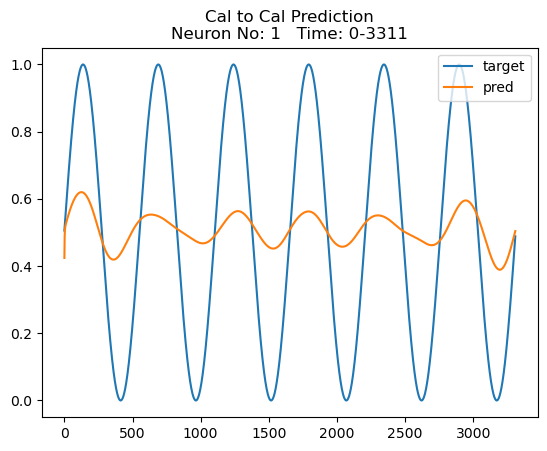

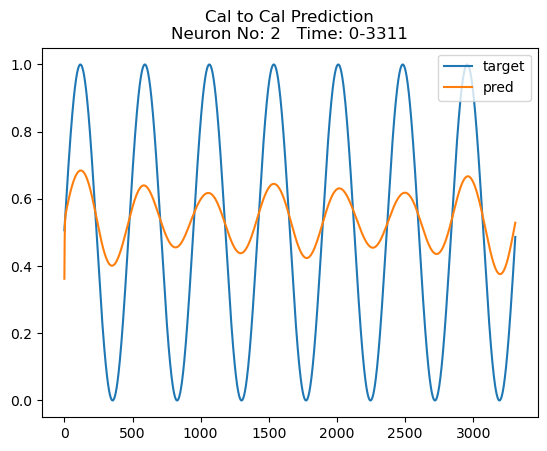

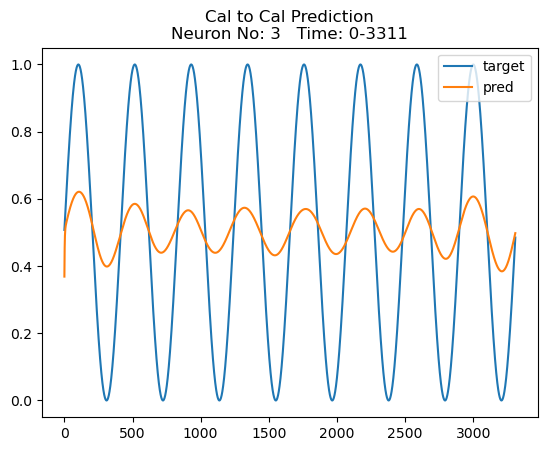

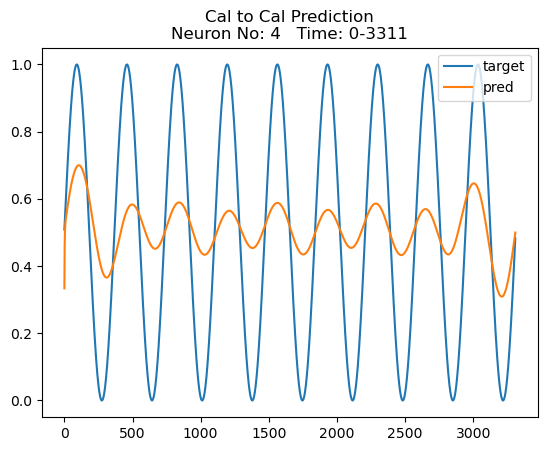

In [ ]:
def draw_pic(Y_pred, Y_test, num, time):
    if time == 3310:
        plt.plot(Y_test.detach().numpy()[0, :, num])
        plt.plot(Y_pred.detach().numpy()[0, :, num])
        plt.legend(["target", "pred"], loc="upper right")
        plt.title("Cal to Cal Prediction\n" + "Neuron No: " + str(num) + "   Time: 0-" + str(time+1))
        plt.show()
    else:
        plt.plot(Y_test.detach().numpy()[:time, 1, num])
        plt.plot(Y_pred.detach().numpy()[:time, 1, num])
        plt.legend(["target", "pred"], loc="upper right")
        plt.title("Cal to Cal Prediction\n" + "Neuron No: " + str(num) + "   Time: 0-" + str(time))
        plt.show()




draw_pic(Y_pred, Y_test, 0, time_step)
draw_pic(Y_pred, Y_test, 1, time_step)
draw_pic(Y_pred, Y_test, 2, time_step)
draw_pic(Y_pred, Y_test, 3, time_step)
draw_pic(Y_pred, Y_test, 4, time_step)

In [ ]:
exit(0)

only the first neuron is active

In [ ]:
from models._utils import *
from data._utils import *
model = NetworkLSTM(CUTDOWN, 64).double()
k = 0
for k in range(0, num_worms_train):
    worm = "worm" + str(k)
    if smoothed:
        calcium_data = dataset[worm]["smooth_calcium_data"][:, 6:6 + CUTDOWN].double()
        residual_calcium = dataset[worm]["residual_smooth_calcium"][:, 6:6 + CUTDOWN].double()
    else:
        calcium_data = dataset[worm]["calcium_data"][:, 6:6 + CUTDOWN].double()
        residual_calcium = dataset[worm]["residual_calcium"][:, 6:6 + CUTDOWN].double()

    cutdown = calcium_data.shape[0]
    train_size = int(0.5 * cutdown)
    print("split: 0.5")
    test_size = cutdown - train_size

    print(calcium_data.shape)

    train_ca, test_ca = calcium_data.split(train_size, dim=0)
    train_res, test_res = residual_calcium.split(train_size, dim=0)

    print(test_ca.shape, "---")

    train_loop_cal = []
    train_loop_res = []
    i = 0
    for i in range(0, train_ca.shape[0] - time_step):
        train_loop_res.append(np.array(train_res[i:i + time_step, :]))
        train_loop_cal.append(np.array(train_ca[i:i + time_step, :]))

    train_loop_cal = torch.tensor(np.array(train_loop_cal))
    train_loop_res = torch.tensor(np.array(train_loop_res))

    # print(train_loop_cal.shape, train_loop_res.shape)

    test_loop_cal = []
    test_loop_res = []
    for i in range(0, test_ca.shape[0] - time_step):
        test_loop_res.append(np.array(test_res[i:i + time_step, :]))
        test_loop_cal.append(np.array(test_ca[i:i + time_step, :]))

    test_loop_cal = torch.tensor(np.array(test_loop_cal))
    test_loop_res = torch.tensor(np.array(test_loop_res))

    train_loop_cal_target = torch.zeros_like(train_loop_cal)
    train_loop_cal_target[:-1] = train_loop_cal[1:]

    test_loop_cal_target = torch.zeros_like(test_loop_cal)
    test_loop_cal_target[:-1] = test_loop_cal[1:]

    train_dataset = torch.utils.data.TensorDataset(train_loop_cal, train_loop_cal_target)
    test_dataset = torch.utils.data.TensorDataset(test_loop_cal, test_loop_cal_target)

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )

    print("\n")
    print("--------worm " + "No. " + str(k) + "--------")
    # train_loader = worm_train[i]
    # test_loader = worm_test[i]
    train_base_loss_history = []
    train_pred_loss_history = []
    test_base_loss_history = []
    test_pred_loss_history = []

    e = 0
    for e in range(EPOCH):
        train_base_loss = 0
        train_pred_loss = 0
        test_base_loss = 0
        test_pred_loss = 0
        count = 0
        for X_train, Y_train in train_loader:
            mask_train = dataset[worm]["named_neurons_mask"][6:6+CUTDOWN].double()
            mask_train = torch.full((mask_train.shape[0], ), False)
            mask_train[0] = True
            X_train, Y_train = torch.tensor(X_train, requires_grad=True), torch.tensor(Y_train, requires_grad=True)
            optimizer.zero_grad()
            # Baseline: loss if the model predicted the residual to be 0
            mask_train = mask_train.unsqueeze(0)
            mask_train = mask_train.repeat(Y_train.shape[0], Y_train.shape[1], 1)
            base = criterion(X_train * mask_train, Y_train * mask_train)
            Y_tr = model(X_train * mask_train)
            # Y_tr.retain_grad()
            # Y_tr.register_hook(lambda grad: grad * mask_train.float())
            loss = criterion(Y_tr * mask_train, Y_train * mask_train)
            loss.backward(retain_graph=True)
            optimizer.step()  # Update parameters based on gradients.
            train_base_loss += base.detach().item()
            train_pred_loss += loss.detach().item()
            count += 1
        train_base_loss_history.append(train_base_loss / count)
        train_pred_loss_history.append(train_pred_loss / count)
        count = 0
        for X_test, Y_test in test_loader:
            mask_test = dataset[worm]["named_neurons_mask"][6:6+CUTDOWN].double()
            mask_test = torch.full((mask_test.shape[0], ), False)
            mask_test[0] = True
            X_test, Y_test = torch.tensor(X_test, requires_grad=True), torch.tensor(Y_test, requires_grad=True)
            optimizer.zero_grad()  # Clear gradients.
            mask_test = mask_test.repeat(Y_test.shape[1], 1)
            mask_test = mask_test.unsqueeze(0)
            mask_test = mask_test.repeat(Y_test.shape[0], 1, 1)
            # Baseline: loss if the model predicted the residual to be 0
            base = criterion(X_test * mask_test, Y_test * mask_test)
            # X_test = X_test.reshape((1, X_test.shape[0], X_test.shape[1])).transpose(1, 2)
            Y_pred = model(X_test * mask_test)  # .transpose(1, 2))  # Forward pass.
            loss = criterion(Y_pred * mask_test, Y_test * mask_test)
            test_base_loss += base.detach().item()
            test_pred_loss += loss.detach().item()
            count += 1
        # print("Count = ", count)
        # print("Test X_test shape = ", X_test.shape)
        # print("Test Y_test shape = ", Y_test.shape)
        test_base_loss_history.append(test_base_loss / count)
        test_pred_loss_history.append(test_pred_loss / count)

        print("epoch = {}, train_loss = {:.4f}, test_loss = {:.4f}".format(e, train_pred_loss_history[-1] -
                                                                           train_base_loss_history[-1],
                                                                           test_pred_loss_history[-1] -
                                                                           test_base_loss_history[-1]))

    delta_train = [train_pred_loss_history[i] - train_base_loss_history[i] for i in
                   range(len(train_base_loss_history))]
    delta_test = [test_pred_loss_history[i] - test_base_loss_history[i] for i in range(len(test_base_loss_history))]
    plt.plot(delta_train)
    plt.plot(delta_test)
    plt.legend(["train", "test"])
    plt.ylabel("Loss-Baseline")
    plt.xlabel("Epoch")
    plt.title("Worm " + str(k) + ", Epoch: " + str(EPOCH) + ", Loss: MSE")
    plt.show()

model_name = "model_LR" + str(LR) + "_E" + str(EPOCH) + "____.pickle"
file = open(model_name, "wb")
torch.save(model.state_dict(), file)

split: 0.5
torch.Size([3312, 5])
torch.Size([1656, 5]) ---


--------worm No. 0--------


ZeroDivisionError: division by zero

In [ ]:
 # if smoothed:
#     calcium_data = dataset[worm]["smooth_calcium_data"]
#     residual_calcium = dataset[worm]["residual_smooth_calcium"]
# else:
#     calcium_data = dataset[worm]["calcium_data"]
#     residual_calcium = dataset[worm]["residual_calcium"]

# file = open("model.pickle", "rb")
# model = torch.load(file)

from train._utils import *



dataset = get_dataset(OmegaConf.load("../../../conf/dataset.yaml"))

model = NetworkLSTM(CUTDOWN, 64).double()
model.load_state_dict((torch.load(model_name)))
model.eval()
calcium_data = dataset["worm0"]["calcium_data"][:, 6:6+CUTDOWN].double()

mask_test = dataset["worm0"]["named_neurons_mask"][6:6+CUTDOWN].double()
mask_test = torch.full((mask_test.shape[0], ), False)
mask_test[0] = True


# visualization of prediction
pred = []
target = []
X_test = []
Y_test = []


time_step = 3310

for i in range(time_step, calcium_data.shape[0] - 1):
    X, Y = calcium_data[i - time_step:i], calcium_data[i-time_step + 1: i+1]
    X_test.append(np.array(X))
    Y_test.append(np.array(Y))

X_test = torch.tensor(X_test)
Y_test = torch.tensor(Y_test)

print(X_test.shape, Y_test.shape, "---")

mask_test = mask_test.repeat(Y_test.shape[1], 1)
mask_test = mask_test.unsqueeze(0)
mask_test = mask_test.repeat(Y_test.shape[0], 1, 1)
# print(mask_test)
Y_test = Y_test * mask_test
Y_pred = model(X_test * mask_test)

Y_test = Y_test.detach().numpy()
Y_pred = Y_pred.detach().numpy()

print(dataset["worm0"]["num_named_neurons"], dataset["worm0"]["num_neurons"])

count = dataset["worm0"]["named_neurons_mask"].sum()
print(count)

# count = 0
# for i in range(0, Y_test.shape[2]):
#     # print(i+count)
#     if i+count >= dataset["worm0"]["named_neurons_mask"].shape[0]: break
#     if i >= Y_test.shape[2]: break
#     if dataset["worm0"]["named_neurons_mask"][i+count].item() is False:
#         Y_test = np.delete(Y_test, i, axis=2)
#         Y_pred = np.delete(Y_pred, i, axis=2)
#         i -= 1
#         count += 1


Y_test = torch.tensor(Y_test)
Y_pred = torch.tensor(Y_pred)

print(Y_pred.shape, Y_test.shape)

In [ ]:
def draw_pic(Y_pred, Y_test, num, time):
    plt.plot(Y_test.detach().numpy()[0, :, num])
    plt.plot(Y_pred.detach().numpy()[0, :, num])
    plt.legend(["target", "pred"], loc="upper right")
    plt.title("Cal to Cal Prediction\n" + "Neuron No: " + str(num) + "   Time: 0-" + str(time))
    plt.show()



draw_pic(Y_pred, Y_test, 0, dataset["worm0"]["max_time"])
draw_pic(Y_pred, Y_test, 1, dataset["worm0"]["max_time"])


draw_pic(Y_pred, Y_test, 2, dataset["worm0"]["max_time"])
draw_pic(Y_pred, Y_test, 3, dataset["worm0"]["max_time"])


draw_pic(Y_pred, Y_test, 4, dataset["worm0"]["max_time"])
# draw_pic(Y_pred, Y_test, 9, dataset["worm0"]["max_time"])
# draw_pic(Y_pred, Y_test, 49, dataset["worm0"]["max_time"])
# draw_pic(Y_pred, Y_test, 60, dataset["worm0"]["max_time"])
# draw_pic(Y_pred, Y_test, 200, dataset["worm0"]["max_time"])
# draw_pic(Y_pred, Y_test, 300, dataset["worm0"]["max_time"])


In [ ]:
 # if smoothed:
#     calcium_data = dataset[worm]["smooth_calcium_data"]
#     residual_calcium = dataset[worm]["residual_smooth_calcium"]
# else:
#     calcium_data = dataset[worm]["calcium_data"]
#     residual_calcium = dataset[worm]["residual_calcium"]

# file = open("model.pickle", "rb")
# model = torch.load(file)

from train._utils import *



dataset = get_dataset(OmegaConf.load("../../../conf/dataset.yaml"))

model = NetworkLSTM(CUTDOWN, 64).double()
model.load_state_dict((torch.load("model_LR0.1_E100.pickle")))
model.eval()
calcium_data = dataset["worm0"]["calcium_data"][:, 6:6+CUTDOWN].double()

mask_test = dataset["worm0"]["named_neurons_mask"][6:6+CUTDOWN].double()
mask_test = torch.full((mask_test.shape[0], ), False)
mask_test[0] = True


# visualization of prediction
pred = []
target = []
X_test = []
Y_test = []


time_step = 3310

for i in range(time_step, calcium_data.shape[0] - 1):
    X, Y = calcium_data[i - time_step:i], calcium_data[i-time_step + 1: i+1]
    X_test.append(np.array(X))
    Y_test.append(np.array(Y))

X_test = torch.tensor(X_test)
Y_test = torch.tensor(Y_test)

print(X_test.shape, Y_test.shape, "---")

mask_test = mask_test.repeat(Y_test.shape[1], 1)
mask_test = mask_test.unsqueeze(0)
mask_test = mask_test.repeat(Y_test.shape[0], 1, 1)
# print(mask_test)
Y_test = Y_test * mask_test
Y_pred = model(X_test * mask_test)

Y_test = Y_test.detach().numpy()
Y_pred = Y_pred.detach().numpy()

print(dataset["worm0"]["num_named_neurons"], dataset["worm0"]["num_neurons"])

count = dataset["worm0"]["named_neurons_mask"].sum()
print(count)

# count = 0
# for i in range(0, Y_test.shape[2]):
#     # print(i+count)
#     if i+count >= dataset["worm0"]["named_neurons_mask"].shape[0]: break
#     if i >= Y_test.shape[2]: break
#     if dataset["worm0"]["named_neurons_mask"][i+count].item() is False:
#         Y_test = np.delete(Y_test, i, axis=2)
#         Y_pred = np.delete(Y_pred, i, axis=2)
#         i -= 1
#         count += 1


Y_test = torch.tensor(Y_test)
Y_pred = torch.tensor(Y_pred)

print(Y_pred.shape, Y_test.shape)

In [ ]:
def draw_pic(Y_pred, Y_test, num, time):
    plt.plot(Y_test.detach().numpy()[0, :, num])
    plt.plot(Y_pred.detach().numpy()[0, :, num])
    plt.legend(["target", "pred"], loc="upper right")
    plt.title("Cal to Cal Prediction\n" + "Neuron No: " + str(num) + "   Time: 0-" + str(time))
    plt.show()



draw_pic(Y_pred, Y_test, 0, dataset["worm0"]["max_time"])
draw_pic(Y_pred, Y_test, 1, dataset["worm0"]["max_time"])


draw_pic(Y_pred, Y_test, 2, dataset["worm0"]["max_time"])
draw_pic(Y_pred, Y_test, 3, dataset["worm0"]["max_time"])


draw_pic(Y_pred, Y_test, 4, dataset["worm0"]["max_time"])
# draw_pic(Y_pred, Y_test, 9, dataset["worm0"]["max_time"])
# draw_pic(Y_pred, Y_test, 49, dataset["worm0"]["max_time"])
# draw_pic(Y_pred, Y_test, 60, dataset["worm0"]["max_time"])
# draw_pic(Y_pred, Y_test, 200, dataset["worm0"]["max_time"])
# draw_pic(Y_pred, Y_test, 300, dataset["worm0"]["max_time"])
